# Modeling

## Business Problem

South by Southwest wants a predictive model that can predict the sentiment of a tweet as either positive, negative, or neutral. They want to use this model on tweets about their event so they can better gauge what people are looking forward to and what they are upset about. This can help with planning events and advertising.

It is important for SXSW this model does not falsely identify tweets as either positive or negative so I will use F1 Score and Accuracy Score as the main metrics for evaluating this model.

In [52]:
# load libraries
import numpy as np
import pandas as pd

# nltk libraries 
import nltk
nltk.download('stopwords', quiet=True)
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# sklearn preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# sklearn metrics and validation
from sklearn.model_selection import cross_validate, cross_val_score,\
train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, \
f1_score, plot_roc_curve, recall_score, classification_report, \
roc_auc_score, make_scorer, plot_confusion_matrix, precision_score

# import xgboost
import xgboost

In [2]:
# load dataset
df = pd.read_csv('./data/tweets_clean.csv', index_col=0)

# look at data 
df.head()

,tweet_text,directed_at,sentiment,company,target,clean_tweet,hashtags,mentions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,negative,i have a 3g iphone after 3 hrs tweeting at it ...,#rise_austin #sxsw,@wesley83
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,positive,know about awesome ipad iphone app that you'll...,#sxsw,@jessedee @fludapp
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,positive,can not wait for 2 also they should sale them ...,#ipad #sxsw,@swonderlin
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,negative,i hope this year's festival isn't as crashy as...,#sxsw,@sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,positive,great stuff on fri marissa mayer google tim o'...,#sxsw,@sxtxstate


In [3]:
df.isna().sum()

tweet_text        0
directed_at       0
sentiment         0
company           0
target            0
clean_tweet       1
hashtags          3
mentions       3899
dtype: int64

In [4]:
# drop null value from clean_tweet
df.dropna(subset=['clean_tweet'], inplace=True)

### Helper Function

In [5]:
# function for printing out metrics and plots
def print_metrics(estimator, X, y):
    
    # plot confusiont matrix
    plot_confusion_matrix(estimator,
                     X=X,
                     y_true=y)
    
    # metrics
    y_pred = estimator.predict(X)

    print('Accuracy score:', round(accuracy_score(y, y_pred), 3))
    print('F1 score:', round(f1_score(y, y_pred, average='weighted'), 3))
    print('Precision score:', round(precision_score(y, y_pred, average='weighted'), 3))
    print('Recall score:', round(recall_score(y, y_pred, average='weighted'), 3))
#     print('ROC AUC score:', round(roc_auc_score(y, estimator.predict_proba(X)[:, 1],average='weighted', multi_class='ovo'), 3))

In [6]:
def print_cross_validate(estimator, X=None, y=None, kfolds=5):
    '''
    Perform cross-validation and prints the test and train scores. 
    '''
    # cross validation
    cv = cross_validate(estimator,
               X=X,
               y=y,
               cv=kfolds,
               scoring=scoring,
               return_train_score=True)
    
    # print scores of cross validation
    print(f"Mean train accuracy score: {round(cv['train_accuracy'].mean(), 3)}")
    print(f"Mean val accuracy score: {round(cv['test_accuracy'].mean(), 3)}")
    print(f"Mean train f1 score: {round(cv['train_f1_score'].mean(), 3)}")
    print(f"Mean val f1 score: {round(cv['test_f1_score'].mean(), 3)}")

In [7]:
# scoring
scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score,average='weighted')}

### Train Test Split

In [8]:
# Set X and y
X = df[['clean_tweet','company','directed_at']]

# mapping target to -1, 0, 1
y = df['target'].map({'negative': -1, 'neutral': 0, 'positive': 1})

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [154]:
X_train.head()

,clean_tweet,company,directed_at
5450,rt apple opening temporary ipad 2 store to han...,Unknown,Unknown
3638,if you're looking for a space to set up meetin...,Unknown,Unknown
1566,apple to open temporary store friday in the sc...,Unknown,Unknown
9049,you can buy my used ipad and i'll pick one up ...,Unknown,Unknown
6322,rt more awesomeness apple is opening up a temp...,Apple,Apple


### Preprocessing

Setting up stopwords and regex patterns

In [9]:
# regex pattern
pattern = "([a-zA-Z0-9]+(?:'[a-z]+)?)"

# stop words
stopwords_list = stopwords.words('english')

# add to stop words
stopwords_list += ['link', 'rt']

## Dummy Model Classifier - Baseline

I'll first use DummyClassifier to set up my baseline model.

In [10]:
# preprocess data
reg_token = RegexpTokenizer(pattern)

# CountVectorizer
count_vec = CountVectorizer(stop_words=stopwords_list, max_features=50)

# fit transform train
X_train_vec = count_vec.fit_transform(X_train['clean_tweet'])
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(count_vec.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [11]:
X_train_vec

,amp,android,app,apple,apps,austin,called,check,circles,day,...,quot,see,social,store,sxsw,temporary,time,today,via,win
5450,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3638,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1566,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
9049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6322,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6118,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Accuracy score: 0.598
F1 score: 0.448
Precision score: 0.358
Recall score: 0.598


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


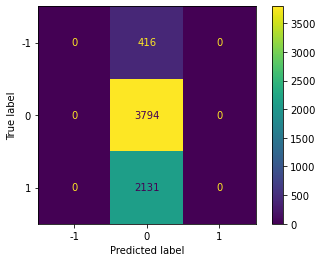

In [13]:
# dummy model pipeline
dum_pipe = Pipeline(steps=[
    ('count_vec', count_vec),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

# fit pipeline with X_train
dum_pipe.fit(X_train['clean_tweet'], y_train)

# print metrics
print_metrics(dum_pipe, X_train['clean_tweet'], y_train)

In [14]:
# cross validate metrics
print_cross_validate(dum_pipe, X_train['clean_tweet'], y_train)

Mean train accuracy score: 0.598
Mean test accuracy score: 0.598
Mean train f1 score: 0.448
Mean test f1 score: 0.448


## Testing Multiple Models

### TF-IDF Vectorizer

In [25]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=5)

# list of models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('tfidf', tfidf),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression()
Mean train accuracy score: 0.698
Mean test accuracy score: 0.646
Mean train f1 score: 0.666
Mean test f1 score: 0.61

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.63
Mean test accuracy score: 0.612
Mean train f1 score: 0.549
Mean test f1 score: 0.527

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.609
Mean test accuracy score: 0.606
Mean train f1 score: 0.471
Mean test f1 score: 0.466

MultinomialNB()
Mean train accuracy score: 0.678
Mean test accuracy score: 0.639
Mean train f1 score: 0.632
Mean test f1 score: 0.587

GradientBoostingClassifier()
Mean train accuracy score: 0.719
Mean test accuracy score: 0.651
Mean train f1 score: 0.677
Mean test f1 score: 0.593



In [18]:
# XGBoost pipeline
xg_pipe = Pipeline(steps=[
    ('tfidf', tfidf),
    ('xgb', xgboost.XGBClassifier(reg_lambda=40))
    ])

# fit pipeline
xg_pipe.fit(X_train['clean_tweet'], y_train)
print_cross_validate(xg_pipe, X_train['clean_tweet'], y_train)

Mean train accuracy score: 0.746
Mean test accuracy score: 0.653
Mean train f1 score: 0.715
Mean test f1 score: 0.611


### Count Vectorizer

In [22]:
# count vectorizer
count_vec = CountVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=5)

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('count_vec', count_vec),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.713
Mean test accuracy score: 0.65
Mean train f1 score: 0.692
Mean test f1 score: 0.623

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.631
Mean test accuracy score: 0.621
Mean train f1 score: 0.532
Mean test f1 score: 0.519

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.608
Mean test accuracy score: 0.607
Mean train f1 score: 0.471
Mean test f1 score: 0.467

MultinomialNB()
Mean train accuracy score: 0.653
Mean test accuracy score: 0.599
Mean train f1 score: 0.655
Mean test f1 score: 0.6

GradientBoostingClassifier()
Mean train accuracy score: 0.711
Mean test accuracy score: 0.66
Mean train f1 score: 0.667
Mean test f1 score: 0.605



In [23]:
# XGBoost pipeline
xg_pipe = Pipeline(steps=[
    ('count_vec', count_vec),
    ('xgb', xgboost.XGBClassifier(reg_lambda=40))
    ])

# fit pipeline
xg_pipe.fit(X_train['clean_tweet'], y_train)
print_cross_validate(xg_pipe, X_train['clean_tweet'], y_train)

Mean train accuracy score: 0.718
Mean test accuracy score: 0.661
Mean train f1 score: 0.681
Mean test f1 score: 0.616


## Initial Evaluation

CountVectorizer and TfIdfVectorizer are performing about the same. Getting validation scores in the high 60% and validation f1 scores in the low 60%. 

I am going to experiment with the following to see if it makes any improvements to the models:
* Add popular words to the stopwords list like apple, ipad, google, quot, store, and more from the EDA notebook.
* Use Lemmatization in the tokenizer
* One hot encode the 'company' column.

Once I finish experimenting with these features I will run a gridsearch on the vectorizer using one of the better performing models. After that I will use the best parameters of the vectorizer and run a grid search on the best performing models to try and tune the hyperparameters to find an optimal model.

## Lemmatization

In [38]:
def lemmatize(tweet):
    # split tweet
    tweet_split = tweet.split()
    
    # tokenize and lemmatize
    lem = WordNetLemmatizer()
    tweet_token = [lem.lemmatize(word) for word in tweet_split]
    return tweet_token

In [42]:
print(X_train['clean_tweet'].iloc[1])
lemmatize(X_train['clean_tweet'].iloc[1])

if you're looking for a space to set up meetings at why don't you stop by arthaus check it out link


['if',
 "you're",
 'looking',
 'for',
 'a',
 'space',
 'to',
 'set',
 'up',
 'meeting',
 'at',
 'why',
 "don't",
 'you',
 'stop',
 'by',
 'arthaus',
 'check',
 'it',
 'out',
 'link']

In [43]:
# TfIdf Vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), 
                        min_df=5, tokenizer=lemmatize)

# list of models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('count_vec', tfidf),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


LogisticRegression()


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\

Mean train accuracy score: 0.702
Mean test accuracy score: 0.649
Mean train f1 score: 0.67
Mean test f1 score: 0.613

DecisionTreeClassifier(max_depth=5)


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\

Mean train accuracy score: 0.63
Mean test accuracy score: 0.614
Mean train f1 score: 0.535
Mean test f1 score: 0.515

RandomForestClassifier(max_depth=5)


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\

Mean train accuracy score: 0.608
Mean test accuracy score: 0.605
Mean train f1 score: 0.469
Mean test f1 score: 0.465

MultinomialNB()


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\

Mean train accuracy score: 0.679
Mean test accuracy score: 0.637
Mean train f1 score: 0.634
Mean test f1 score: 0.585

GradientBoostingClassifier()


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\

Mean train accuracy score: 0.722
Mean test accuracy score: 0.653
Mean train f1 score: 0.681
Mean test f1 score: 0.596



In [32]:
X_train['clean_tweet'].iloc[0]

'rt apple opening temporary ipad 2 store to handle demand link'

In [37]:
WordNetLemmatizer().lemmatize(X_train['clean_tweet'].iloc[0])

'rt apple opening temporary ipad 2 store to handle demand link'

## Adding Additional Stopwords

### TF-IDF Vectorizer

In [49]:
# adding additional words to stopwords_list
new_stopwords_list = stopwords_list
new_stopwords_list += ['ipad', 'apple', 'google', 'store', 'iphone', 'quot']

In [50]:
# TfIdf Vectorizer
tfidf = TfidfVectorizer(stop_words=new_stopwords_list, max_features=500, ngram_range=(1,3), 
                        min_df=5)

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('count_vec', tfidf),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.698
Mean test accuracy score: 0.642
Mean train f1 score: 0.666
Mean test f1 score: 0.606

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.635
Mean test accuracy score: 0.624
Mean train f1 score: 0.562
Mean test f1 score: 0.549

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.607
Mean test accuracy score: 0.606
Mean train f1 score: 0.467
Mean test f1 score: 0.465

MultinomialNB()
Mean train accuracy score: 0.682
Mean test accuracy score: 0.643
Mean train f1 score: 0.639
Mean test f1 score: 0.594

GradientBoostingClassifier()
Mean train accuracy score: 0.716
Mean test accuracy score: 0.65
Mean train f1 score: 0.672
Mean test f1 score: 0.593



### Count Vectorizer

In [51]:
# count vectorizer
count_vec = CountVectorizer(stop_words=new_stopwords_list, max_features=500, ngram_range=(1,3), min_df=5)

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('count_vec', count_vec),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.709
Mean test accuracy score: 0.647
Mean train f1 score: 0.687
Mean test f1 score: 0.617

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.631
Mean test accuracy score: 0.619
Mean train f1 score: 0.549
Mean test f1 score: 0.535

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.608
Mean test accuracy score: 0.606
Mean train f1 score: 0.469
Mean test f1 score: 0.466

MultinomialNB()
Mean train accuracy score: 0.663
Mean test accuracy score: 0.611
Mean train f1 score: 0.66
Mean test f1 score: 0.605

GradientBoostingClassifier()
Mean train accuracy score: 0.709
Mean test accuracy score: 0.657
Mean train f1 score: 0.665
Mean test f1 score: 0.603



## One Hot Encoder 'company'

In [56]:
X_train.company.value_counts()

Unknown    4001
Apple      1714
Google      626
Name: company, dtype: int64

In [104]:
# function to turn series to dataframe
def series_to_dataframe(series):
    return pd.DataFrame(series)

# Function Transformer
series_FT = FunctionTransformer(series_to_dataframe)

In [159]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=new_stopwords_list, max_features=500, ngram_range=(1,3))
# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['company'])
], remainder='passthrough')

# logreg pipeline
logreg_pipe = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [160]:
logreg_pipe.fit(X_train[['clean_tweet', 'company']], y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vector_pipe',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000020BCE6181F0>)),
                                                                  ('vector',
                                                                   TfidfVectorizer(max_features=500,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   stop_words=['i',
                                                                                               'me',
                                                            

Accuracy score: 0.902
F1 score: 0.888
Precision score: 0.9
Recall score: 0.902


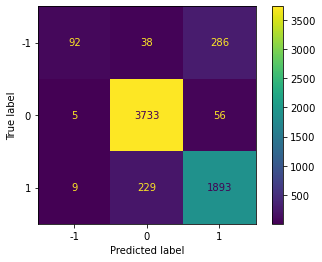

In [144]:
print_metrics(logreg_pipe, X_train[['clean_tweet','company']],y_train)

In [145]:
print_cross_validate(logreg_pipe, X_train[['clean_tweet','company']],y_train)

Mean train accuracy score: 0.901
Mean test accuracy score: 0.894
Mean train f1 score: 0.886
Mean test f1 score: 0.875


In [151]:
# company one hot encode
X_train_company = ohe_pipe.fit_transform(X_train['company'])
X_train_company = pd.DataFrame(X_train_company)
X_train_company

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
...,...,...,...
6336,0.0,0.0,1.0
6337,0.0,0.0,1.0
6338,0.0,0.0,1.0
6339,0.0,0.0,1.0


Accuracy score: 0.889
F1 score: 0.859
Precision score: 0.831
Recall score: 0.889
Mean train accuracy score: 0.889
Mean test accuracy score: 0.889
Mean train f1 score: 0.859
Mean test f1 score: 0.859


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


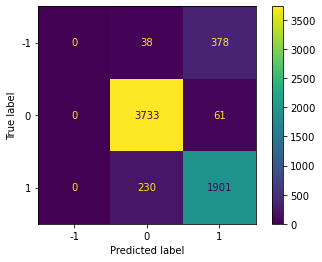

In [153]:
logreg = LogisticRegression()
logreg.fit(X_train_company, y_train)
print_metrics(logreg, X_train_company, y_train)
print_cross_validate(logreg, X_train_company, y_train)

In [156]:
# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['company'])
], remainder='passthrough')

# logreg pipeline
logreg_pipe = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(max_iter=1000))
])

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('ct', CT),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train[['clean_tweet', 'company']], y_train)
    print(model)
    print_cross_validate(pipe, X_train[['clean_tweet', 'company']], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.901
Mean test accuracy score: 0.894
Mean train f1 score: 0.886
Mean test f1 score: 0.875

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.896
Mean test accuracy score: 0.889
Mean train f1 score: 0.875
Mean test f1 score: 0.865

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.835
Mean test accuracy score: 0.823
Mean train f1 score: 0.799
Mean test f1 score: 0.785

MultinomialNB()
Mean train accuracy score: 0.894
Mean test accuracy score: 0.892
Mean train f1 score: 0.873
Mean test f1 score: 0.869

GradientBoostingClassifier()
Mean train accuracy score: 0.905
Mean test accuracy score: 0.889
Mean train f1 score: 0.891
Mean test f1 score: 0.867

